# 分割断面法のプログラミング

 - 前回定義したクラスsectionを利用する。
 - 分割断面法は、各断面を複数の領域に分割するため、クラスsectionをクラスsubsectionと再定義して、複数のsubsectionの集合が新たなクラスsectionとなるように定義する。

In [1]:
import numpy as np

In [2]:
class subsection(object):
    def __init__(self, x, y, n):
        self.x = x
        self.y = y
        self.n = n

    def H2ABSKn(self, H): #変更:引数は水位のみ
        A, B, S, SN = float(0), float(0), float(0), float(0)
        x = self.x #変更:メンバ変数を参照
        y = self.y #変更:メンバ変数を参照
        n = self.n #変更:メンバ変数を参照
        
        for i in range(1, len(x)):
            dx = x[i] - x[i-1]    
            dy = y[i] - y[i-1]    
            hb, hf = H - y[i-1], H - y[i]
            
            if hb <= float(0) :
                if hf > float(0) :
                    dx_dh = dx / (hf - hb)
                    B += hf * dx_dh
                    A += 0.5 * hf * hf * dx_dh
                    Sp = hf * np.sqrt( dx_dh * dx_dh + 1.0)
                    S +=  Sp
                    SN += Sp * n[i-1]**1.5
            elif hf <= float(0) :
                if hb > float(0) :
                    dx_dh = dx / (hf - hb)
                    B -= hb * dx_dh
                    A -= 0.5 * hb * hb * dx_dh
                    Sp = hb * np.sqrt(dx_dh * dx_dh + 1.0)
                    S += Sp
                    SN += Sp * n[i-1]**1.5
            else :
                B += dx
                A += 0.5 * dx * (hf + hb)
                Sp = np.sqrt(dx**2 + dy**2)
                S += Sp
                SN += Sp * n[i-1]**1.5
                
        if S <= float(0):
            nd = float(0)
            K = float(0)
        else:
            nd = (SN/S)**(2.0/3.0)
            K = A**(5.0/3.0)/nd/S**(2.0/3.0)
            
        return A, B, S, K, nd

下図のように分割断面を設定する。

In [3]:
x=np.array([0, 5,93,100,200,206,294,300])
y=np.array([6, 3.5, 3.5,  0,  0,  3,  3,  6])
n=np.array([0.041, 0.041,0.030,0.030,0.030,0.040,0.040])

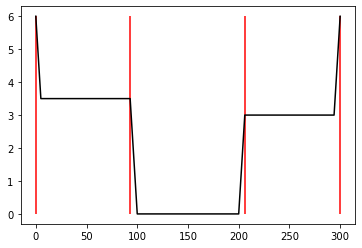

In [4]:
import matplotlib.pyplot as plt
plt.plot(x,y, c='k')
plt.vlines([0,93,206,300], ymin=0, ymax=6, color='r')
plt.show()                # 描画

左岸側の高水敷のsubsectionは次のとおりに定義できる。

In [5]:
sub = subsection( x[0:3], y[0:3], n[0:2] )

In [6]:
A, B, S, K, nd = sub.H2ABSKn(5.0)
print('河積：{}\n水面幅：{}\n潤辺：{}\n通水能：{}\n合成粗度係数：{}'.format(A, B, S, K, nd))

河積：134.25
水面幅：91.0
潤辺：91.35410196624969
通水能：4232.411951420601
合成粗度係数：0.04100000000000001


同様にすべてのsubsectionを含めた配列を作成する。

その際に境界の座標点は重複させる。

In [7]:
section = [ subsection( x[0:3], y[0:3], n[0:2] )
            , subsection( x[2:6], y[2:6], n[2:5] )
            , subsection( x[5:], y[5:], n[5:] )
          ]

次にsubsectionの配列となるクラスsectionを定義する。

In [8]:
class section(object):
    def __init__(self, section):
        self.subsections = section

となるが、より抽象度を高めて以下のように定義する。

In [9]:
X = [x[0:3], x[2:6], x[5:]]
Y = [y[0:3], y[2:6], y[5:]]
N = [n[0:2], n[2:5], n[5:]]

In [10]:
class section(object):
    def __init__(self, X, Y, N):
        self._subsections = [subsection(x,y,n) for x,y,n in zip(X,Y,N)]

※ クラスのメンバ変数名の最初の_はクラスの外からアクセスして欲しくないことを示す暗黙のルール。pythonではprivate変数は設定できない。

前回はLと定義した下流端からの追加距離をdistanceとして追加

In [11]:
class section(object):
    def __init__(self, X, Y, N, distance=np.nan):
        self._subsections = [subsection(x,y,n) for x,y,n in zip(X,Y,N)]
        self.distance = distance

次に断面の諸元を計算するメソッドを定義する。

A,B,S,Kはsubsectionごと値の総和をとる。

In [12]:
class section(object):
    def __init__(self, X, Y, N, distance=np.nan):
        self._subsections = [subsection(x,y,n) for x,y,n in zip(X,Y,N)]
        self.distance = distance
        
    def H2ABSKnSub(self, H):
        num = len(self._subsections)
        A = np.zeros(num)
        B = np.zeros(num)
        S = np.zeros(num)
        K = np.zeros(num)
        n = np.zeros(num)
            
        for nump in range(num) : 
            A[nump], B[nump], S[nump], K[nump], n[nump] = self._subsections[nump].H2ABSKn(H)
            
        return A, B, S, K, n
    
    def H2ABSK(self, H):
        A, B, S, K, n = self.H2ABSKnSub(H)
        return np.sum(A), np.sum(B), np.sum(S), np.sum(K)

水位が5のときのA,B,S,Kを計算すると以下のとおりとなる。

断面全体の粗度係数は総和では計算できないため、計算に含めていない。

In [13]:
X = [x[0:3], x[2:6], x[5:]]
Y = [y[0:3], y[2:6], y[5:]]
N = [n[0:2], n[2:5], n[5:]]

s = section(X,Y,N,0)
A,B,S,K = s.H2ABSK(5.0)
print('河積：{}\n水面幅：{}\n潤辺：{}\n通水能：{}'.format(A, B, S, K))

河積：858.0
水面幅：296.0
潤辺：298.3606797749979
通水能：62445.88519359645


課題と同様に、水位を0.01～6.0まで変化させて場合の以下の諸元を計算する。
 - 通水能（y軸：水位、x軸：通水能）

In [14]:
Harr = np.arange(0.01,6.001,0.01)
Karr = np.zeros_like(Harr)

for i, H in enumerate(Harr) : 
    _,_,_,Karr[i] = s.H2ABSK(H)

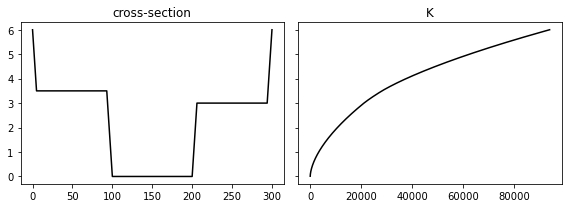

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(8,3), tight_layout=True, sharey="all")
axes[0].plot(x, y, c='k')
axes[1].plot(Karr, Harr , c='k')
axes[0].set_title('cross-section')
axes[1].set_title('K')
# plt.savefig('tmp.png', bbox_inches="tight", facecolor="white")
plt.show()                # 描画

さらに、流量$1000 \mathrm{m^3/s}$、河床勾配$1/300$における$\dfrac{\tau}{\rho g A} = \dfrac{Q^2}{(\sum K)^2}$と$H$の関係は以下となる。

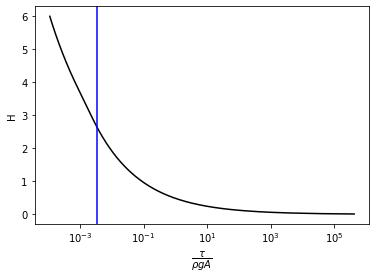

In [16]:
Q = 1000
plt.plot(Q**2/Karr**2, Harr, c='k')
plt.xscale('log')
plt.axvline(x=1/300, c='b')
plt.xlabel(r'$\dfrac{\tau}{\rho g A}$')
plt.ylabel(r'H')
plt.show()                # 描画